## Training eines neuronalen Netzes zur Erkennung von Ziffern

Bei Training der Snake-KI und beim Training des Chat-Bots haben wir neuronale Netze als "Black Box" verwendet. Heute wollen wir uns etwas genauer anschauen, wie das Training eines neuronalen Netzes funktioniert.

Wenn man eine neue Programmiersprache lernt, beginnt man meistens mit einem *Hello World* – einem kleinen Programm, das die Meldung `Hello World!` ausgibt.
Im Bereich der KI bzw. des maschinellen Lernens verwendet man gerne den *[MNIST Datensatz](https://de.wikipedia.org/wiki/MNIST-Datenbank)* als Beispiel verwendet.

In diesem Praktikum geht es um folgende Punkte:

**1. Wie trainiert man ein neuronales Netz?**<br>
   Wir lernen, wie man
   - Trainingsdaten lädt,
   - ein neuronales Netz aufbaut,
   - das neuronale Netz trainiert und
   - die Qualität des Netzes misst.


**2. Wovon hängt die Qualität der Erkennung ab?**<br>
   Jenachdem, 
   - wie wir unser Netz bauen, 
   - wie viele Trainingsdaten wir verwenden und 
   - wie lange wir das Netz trainieren
   sind die Ergebnisse besser oder schlechter. Dabei gibt es typische Probleme, die beim Training von KI-Modellen immer wieder auftauchen. Wie beim Fußball ist es 
   wichtig, als "Trainer" diese Probleme zu erkennen und zu wissen, was man dagegen tun kann.


In diesem Praktikum verwenden wir ein *Jupyter Notebook*. Darin kann man Erklärungen direkt in das Programm einbauen. Die folgende *Code-Zelle* gibt `Hello World!` aus, wenn Du sie ausführst.

In [1]:
print("Hello World!")

Hello World!


Hier geht es mit dem Trainingsprogramm los. Die folgende Code-Zelle importiert die notwendigen Bibliotheken, die wir im folgenden benötigen.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

### Trainingsdaten laden

Jetzt laden wir die Trainingsdaten aus dem Internet und schauen uns ein paar Beispiele an:

In [3]:
train_set = datasets.MNIST(root="", train=True, transform=transforms.ToTensor(), download=True)
test_set = datasets.MNIST(root="", train=False, transform=transforms.ToTensor(), download=True)

0it [00:00, ?it/s]

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw


0it [00:00, ?it/s]

Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw


0it [00:00, ?it/s]

Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw


0it [00:00, ?it/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw
Processing...
Done!


/opt/tljh/user/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Wähle die ersten 500 Trainingsdatensätze aus.

In [4]:
N = 500
train_set.data = train_set.data[:N, :, :]

In [5]:
print("train_set shape: ", train_set.data.shape)
print("test_set shape: ", test_set.data.shape)

train_set shape:  torch.Size([500, 28, 28])
test_set shape:  torch.Size([10000, 28, 28])


In [6]:
train_loader = DataLoader(train_set, batch_size=64, pin_memory=True, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, pin_memory=True, shuffle=True)

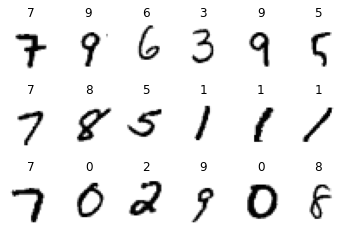

In [7]:
for images, labels in train_loader:
    # Wir laden die erste Portion Daten
    break;
    
figure = plt.figure()
num_images = 18
for i in range(num_images):
    plt.subplot(3, 6, i+1, title=f"{labels[i]}")
    plt.axis("off")
    plt.imshow(images[i].cpu().numpy().squeeze(), cmap="gray_r")

In [8]:
hidden_size = 2

class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        
        self.fc1 = nn.Linear(28*28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 10)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = x.view(-1, 28*28)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        
        return out

In [9]:
model = ANN()

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

#model = model.cuda()

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

1600

In [ ]:
training_loss = []
testing_loss = []
training_acc = []
testing_acc = []

epochs = 500

with tqdm(range(epochs)) as iterator:

    for epoch in iterator:
        train_loss = 0
        train_acc = 0

        model.train()
        for images, labels in train_loader:
            #images, labels = images.cuda(), labels.cuda()
            output = model(images)
            optimizer.zero_grad()
            loss = loss_fn(output, labels)

            loss.backward()
            optimizer.step()

            prediction = torch.argmax(output, 1)
            train_acc += (prediction == labels).sum().item()
            train_loss += loss.item()

        training_acc.append(train_acc/len(train_set))
        training_loss.append(train_loss/len(train_set))

        test_loss = 0
        test_acc = 0
        with torch.no_grad():
            for images, labels in test_loader:
                #images, labels = images.cuda(), labels.cuda()
                output = model(images)
                loss = loss_fn(output, labels)
                prediction = torch.argmax(output, 1)
                test_acc += (prediction == labels).sum().item()
                test_loss += loss.item()        
            testing_acc.append(test_acc/len(test_set))
            testing_loss.append(test_loss/len(test_set))

        iterator.set_postfix_str(f"train_acc: {train_acc/len(train_set):.2f} test_acc: {test_acc/len(test_set):.2f} train_loss: {train_loss/len(train_set):.2f} test_loss: {test_loss/len(test_set):.2f}")

  0%|          | 0/500 [00:00<?, ?it/s]

[]

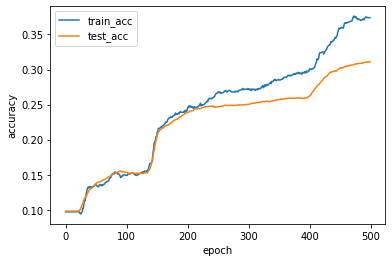

In [52]:
plt.plot(range(epochs), training_acc, label="train_acc")
plt.plot(range(epochs), testing_acc, label="test_acc")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot()

[]

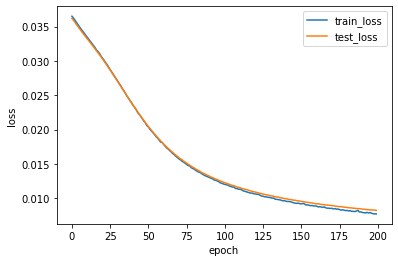

In [34]:
plt.plot(range(epochs), training_loss, label="train_loss")
plt.plot(range(epochs), testing_loss, label="test_loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot()